# Assignment 5: Monte Carlo Interactions (Physics 420)

Write a simple Monte Carlo to calculate diffusion of a single argon atom in argon gas, taking the origin as the position of the atom at time t=0.  Assume the gas is at standard temperature and pressure (ie.  one mole is 22.7 liters at 100 kPa and 273 K).  Throw the energy of gas molecules according to the Maxwell Boltzmann distribution(below).  The mean free path for argon is 6.2e-6 cm at 273 K.  Treat the atoms as "hard spheres" with radius 3.67e-8 cm.  Calculate the collisions in the center of mass. For hard spheres the angle of incidence=angle of reflection, where the angle is measured between the velocity and the line from the center of the sphere to the point of impact.   

Calculate:
1.  The number of collisions/second.  (Simulate a million collisions and find the time to calculate this).  
2.  Plot the distance from the origin the atom travels as a function of time.
3.  The energy distribution of the particle as it bounces. 
4.  Redo the calculation for as many particles and as long a time as is practical on your computer.  (Limit your calculation times to a few hours).  

From Wikipedia, we find Maxwell Boltmann distribution is defined as:
Assuming the system of interest contains a large number of particles, the fraction of the particles within an infinitesimal element of three-dimensional velocity space, ${\displaystyle d^{3}v},$ centered on a velocity vector of magnitude ${\displaystyle v}$, is ${\displaystyle f(v)d^{3}v}$, in which

$${\displaystyle f(v)~\mathrm {d} ^{3}v=\left({\frac {m}{2\pi kT}}\right)^{3/2}\,e^{-{\frac {mv^{2}}{2kT}}}~\mathrm {d} ^{3}v,}$$
where ${\displaystyle m} $ is the particle mass and ${\displaystyle kT}$ is the product of Boltzmann's constant and thermodynamic temperature.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import matplotlib as mpl
from pprint import pprint
import pandas as pd

m = (39.948/(6.022*10**23))/1000 #one argon atom
T = 273.15
k = 1.38064852*10**-23
argonRadius = 3.67e-8/100

np.random.seed(3)

In [2]:
mpl.rc('figure',dpi=250)
mpl.rc('text',usetex=True)

# Note

I have coded Hallin's way of drawing samples using Monte Carlo, but it is actually just more convienient to use np.random.normal and set the variance and mean to fit the maxwell Boltzmann distribution. This is due to the fact that a maxwell boltzmann distribution is just
a special case of a gaussian. As a result, this code is only for show.

(array([1.15621175e-05, 4.23944309e-05, 8.09348226e-05, 2.04264076e-04,
        4.39360465e-04, 6.28208385e-04, 1.04059058e-03, 1.32964351e-03,
        1.54932375e-03, 1.61098837e-03, 1.54161567e-03, 1.20631426e-03,
        8.86429009e-04, 4.54776622e-04, 2.96761016e-04, 1.50307528e-04,
        5.01025092e-05, 2.69782742e-05, 7.70807834e-06, 7.70807834e-06]),
 array([-803.8009408 , -717.34041338, -630.87988596, -544.41935855,
        -457.95883113, -371.49830371, -285.03777629, -198.57724888,
        -112.11672146,  -25.65619404,   60.80433338,  147.26486079,
         233.72538821,  320.18591563,  406.64644305,  493.10697046,
         579.56749788,  666.0280253 ,  752.48855272,  838.94908013,
         925.40960755]),
 <a list of 20 Patch objects>)

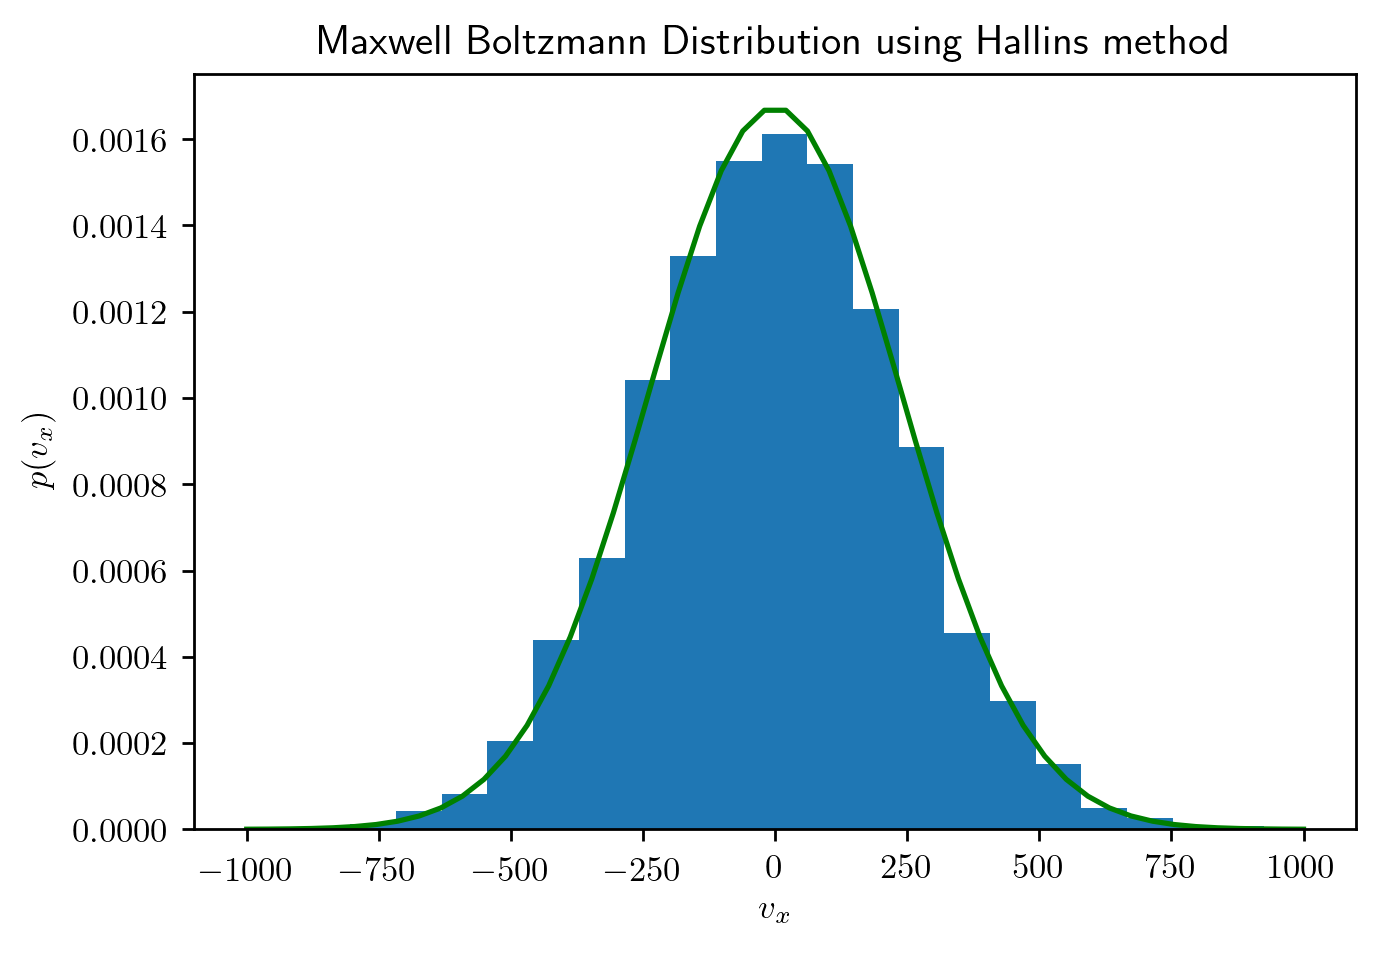

In [3]:


v = np.linspace(-1000, 1000)

def maxwell_boltzmann(v):
    '''Maxwell Boltzmann in 1-D'''    
    return (m/(2*np.pi*k*T))**(1/2)*np.exp(-m*v**2/(2*k*T))

normalization_factor = quad(lambda v: maxwell_boltzmann(v), -1000, 1000)[0]
normalization_factor

def maxwell_boltzmann_normalized(v):
    return maxwell_boltzmann(v)/normalization_factor

def generate_samples(N=10000):
    v_max = max(maxwell_boltzmann_normalized(v))
    
    x_rand = np.random.uniform(-1000, 1000, size=N)
    y_rand = np.random.uniform(0, v_max, size=N)
    
    samples = x_rand[y_rand < maxwell_boltzmann_normalized(x_rand)]
    
    return samples.reshape(len(samples), 1)

x = generate_samples()


plt.plot(v, maxwell_boltzmann_normalized(v), c='g')
plt.xlabel('$v_x$')
plt.ylabel('$p(v_x)$')
plt.title('Maxwell Boltzmann Distribution using Hallins method')

plt.hist(x, bins=20, density=True)

# Assignment starts here

Also, I realize that my solution is a lot more tedious than other peoples, but as we will see in the end this is more of an experimental justification of the theory, as my meanfreepath is an output rather than an input. We see that the freepath distribution follows the same curve as the exponential distribution, which agrees with the theory!

For this simulation, we study what properties Argon at SATP has, 50000 particles. The container is 1e-7 width, but I use periodic boundary conditions to extend the container to all positions. 

In [4]:
# Here we draw the samples from a Gaussian, which is fit to the Maxwell Boltzmann.

velocities = np.empty((50000, 3), dtype='float64')
velocities = np.random.normal(0, scale=np.sqrt((k*T)/m), size=(50000, 3))

velocity_x = velocities[:, 0]
velocity_y = velocities[:, 1]
velocity_z = velocities[:, 2]

Text(0.5, 1.0, 'Maxwell Boltzmann Distribution using scipy')

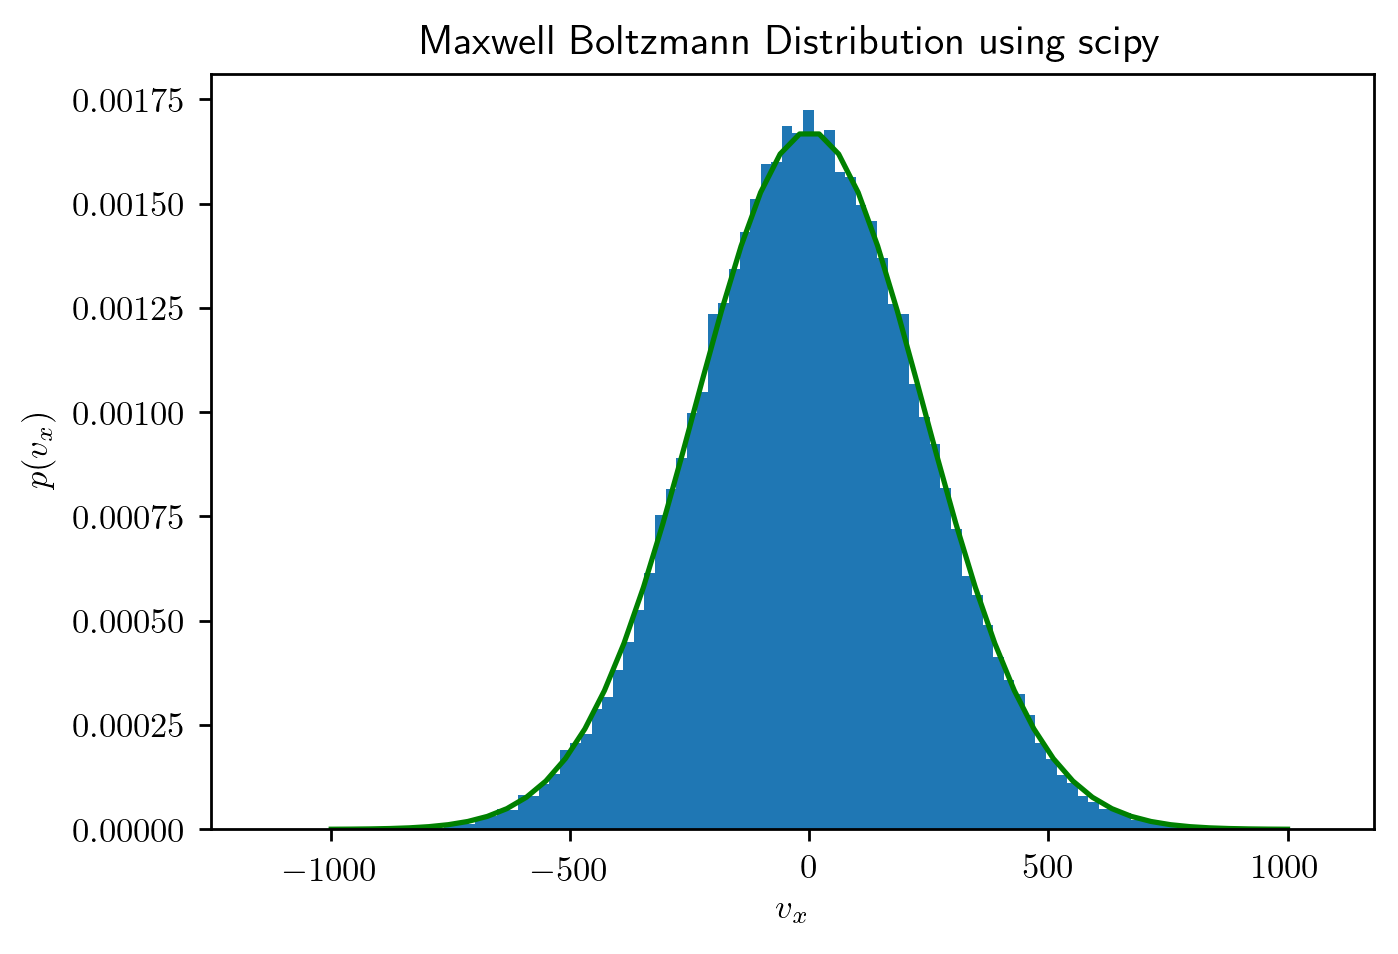

In [5]:
plt.plot(v, maxwell_boltzmann_normalized(v), c='g')
plt.hist(velocity_x, bins=100, density=True)
plt.xlabel('$v_x$')
plt.ylabel('$p(v_x)$')
plt.title('Maxwell Boltzmann Distribution using scipy')

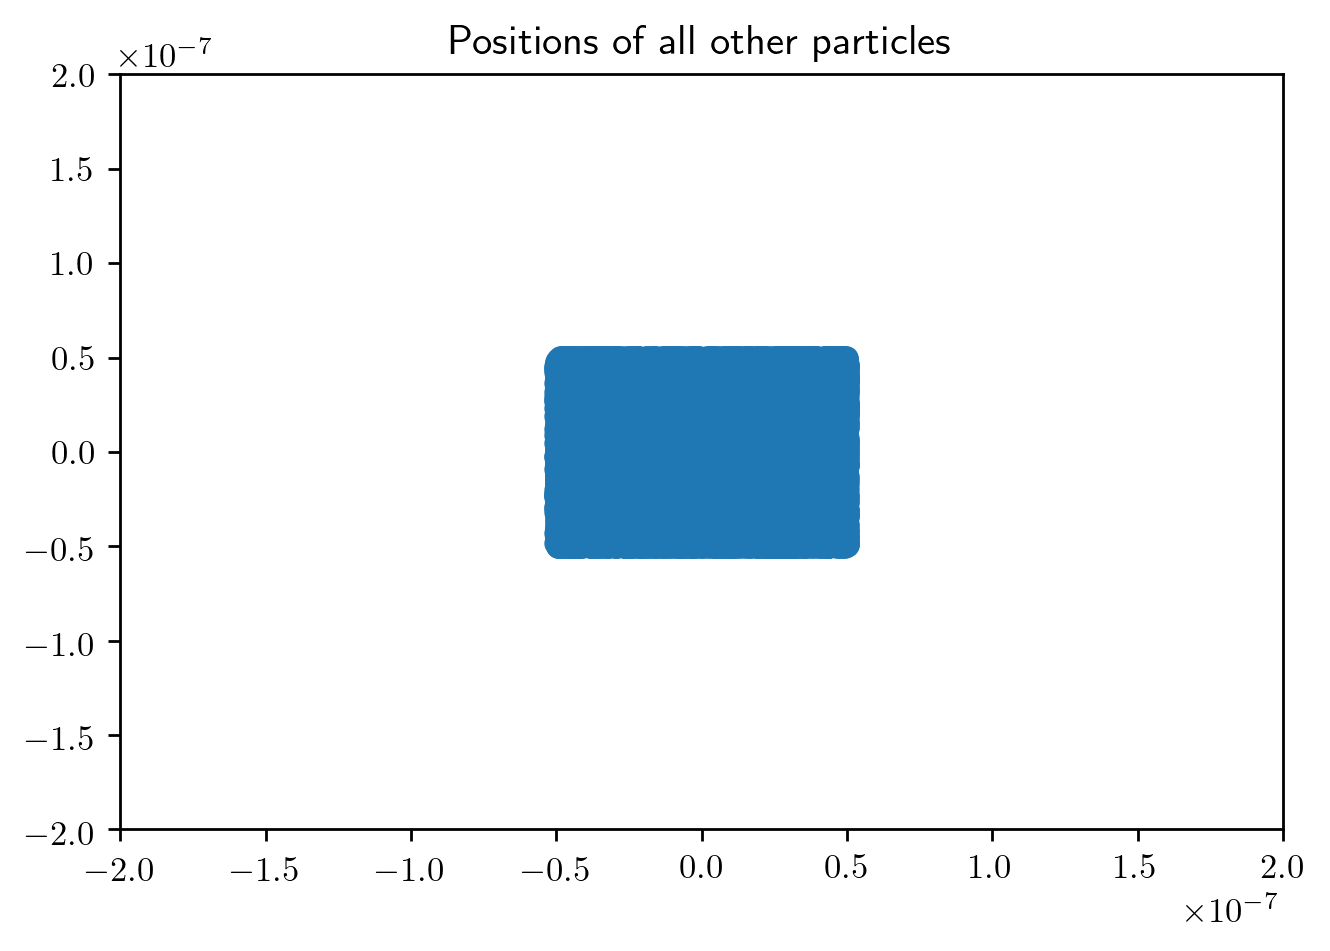

In [6]:
wallRadius = 0.5*1e-7

positions = np.empty((50000, 3), dtype='float64')
positions = np.random.uniform(-wallRadius, wallRadius ,size=(50000, 3))
positions

plt.scatter(positions[:, 0], positions[:, 1])
plt.title('Positions of all other particles')
plt.xlim(-4*wallRadius, 4*wallRadius)
plt.ylim(-4*wallRadius, 4*wallRadius)

unique_energies = []
free_path = []

In [7]:
class Argon:
    def __init__(self, position, velocity):
        self.position = position.copy() #long term running total 
        self.velocity = velocity
        self.radius = argonRadius
        self.dist = 0
        self.collisions = 0
        self.dx = 0
        self.energy = 0
        
        self.box_position = position.copy() #position inside the box
        self.position_before_last_collision = 0
        
    def update_dt(self):
        self.dist += np.linalg.norm(self.velocity*dt)
        
        self.position += self.velocity*dt
        self.box_position += self.velocity*dt
        
        self.position_before_last_collision += np.linalg.norm(self.velocity*dt)
        
        self.dx = np.linalg.norm(self.velocity*dt)
        self.energy = (1/2)*(self.velocity.T @ self.velocity)*m
         
    def check_collision(self, atom):
        if np.linalg.norm(self.box_position - atom.position) < 2*self.radius:
            # since the second particle doesn't matter, by Kenny's great wisdom
            self.velocity = np.random.normal(0, scale=np.sqrt((k*T)/m), size=(3))
            print('collide')
            self.collisions += 1
            
            free_path.append(self.position_before_last_collision)
            self.position_before_last_collision = 0
            unique_energies.append(self.energy)
            

    def check_bounds(self):
        for i in range(3):
            if (np.abs(self.box_position[i]) >= wallRadius):
                self.box_position[i] %= wallRadius
                #print('out of bounds', self.position, self.box_position, self.velocity)
           

In [8]:
#Expected time: 2minutes on my laptop
import time
start = time.time()
mainArgon = Argon(np.array([0,0,0], dtype='float64') , velocities[0])
dt = 1e-11
meanFreePath = 6.2e-6/100

atoms = []
data = []

unique_energies = []
free_path = []

for i in range(1, 50000):
    atoms.append(Argon(positions[i], velocities[i]))
    
def simulate():
    for atom in atoms:
        mainArgon.check_collision(atom)
    
    mainArgondata = {'pos_x':mainArgon.position.copy()[0],
                     'pos_y':mainArgon.position.copy()[1],
                     'pos_z':mainArgon.position.copy()[2],
                     'box_pos_x':mainArgon.box_position.copy()[0],
                     'box_pos_y':mainArgon.box_position.copy()[1],
                     'box_pos_z':mainArgon.box_position.copy()[2],
                     'vel_x': mainArgon.velocity.copy()[0],
                     'vel_y': mainArgon.velocity.copy()[1],
                     'vel_z': mainArgon.velocity.copy()[2],
                     't':t,
                     'change_pos':mainArgon.dx,
                     'energy':mainArgon.energy,
                     'collisions':mainArgon.collisions}
    
    #pprint(mainArgondata)
    data.append(mainArgondata)
    
    mainArgon.check_bounds()
    mainArgon.update_dt()
    

for i, t in enumerate(np.arange(0, dt*300, dt)):
    simulate()
    
    if i%5 == 0:
        print(f'{100*(i/300)}% done')
    

df = pd.DataFrame(data)
df.to_csv('monteCarlo_particle.csv', index=False)
np.save('free_paths', np.array(free_path))

print(f'Calculation took {time.time() - start} s')

0.0% done
1.6666666666666667% done
collide
3.3333333333333335% done
5.0% done
6.666666666666667% done
8.333333333333332% done
10.0% done
collide
11.666666666666666% done
collide
13.333333333333334% done
collide
15.0% done
16.666666666666664% done
18.333333333333332% done
20.0% done
21.666666666666668% done
23.333333333333332% done
25.0% done
26.666666666666668% done
collide
28.333333333333332% done
30.0% done
31.666666666666664% done
33.33333333333333% done
35.0% done
36.666666666666664% done
collide
38.333333333333336% done
40.0% done
41.66666666666667% done
43.333333333333336% done
collide
45.0% done
46.666666666666664% done
collide
48.333333333333336% done
50.0% done
collide
collide
51.66666666666667% done
53.333333333333336% done
55.00000000000001% done
56.666666666666664% done
58.333333333333336% done
60.0% done
collide
61.66666666666667% done
collide
63.33333333333333% done
65.0% done
66.66666666666666% done
68.33333333333333% done
collide
70.0% done
71.66666666666667% done
colli

## Question 1

Collisions per second: 7692307692.307693


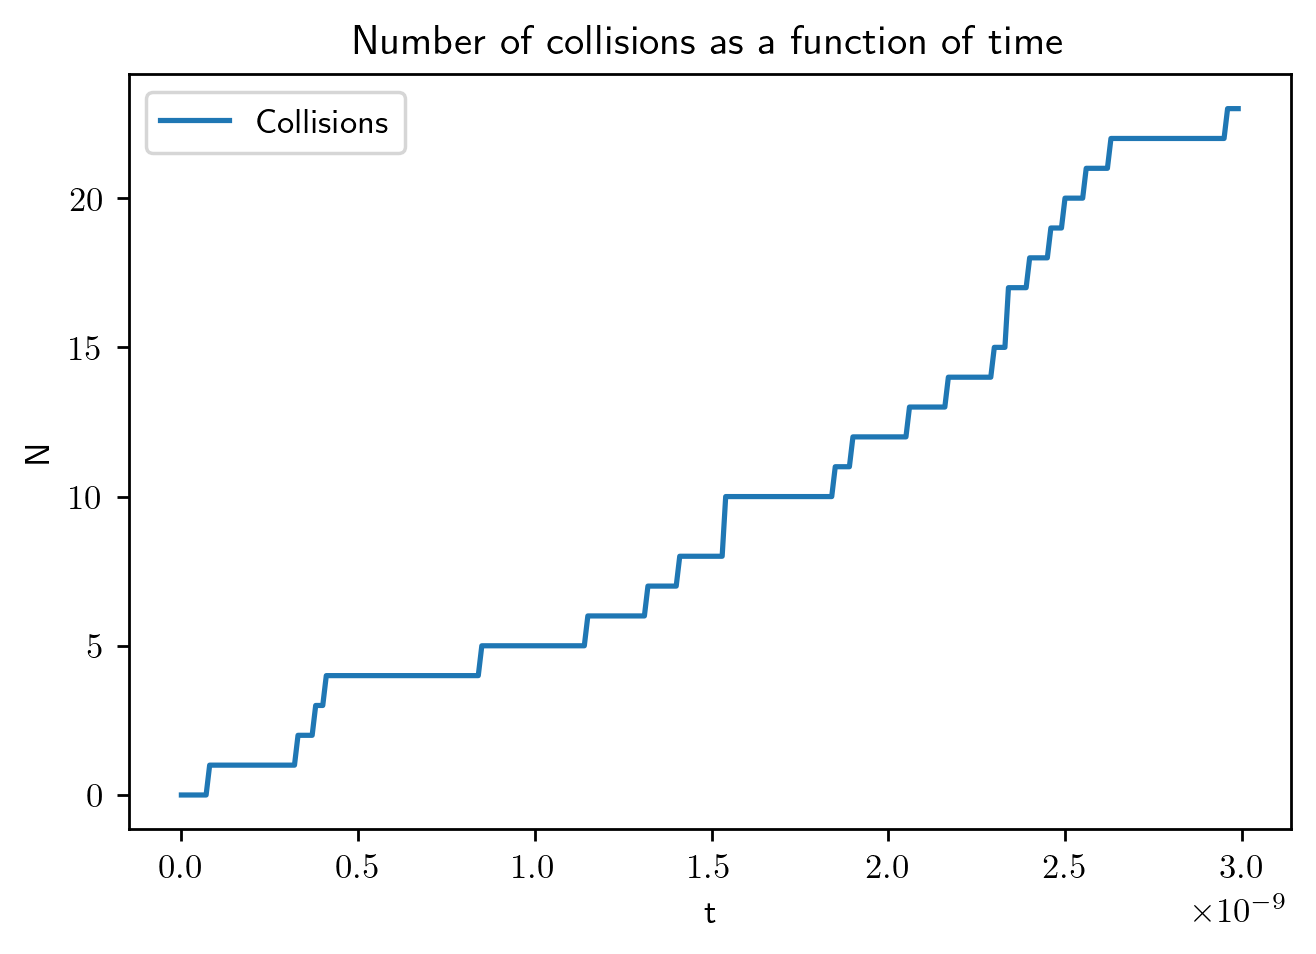

In [9]:
plt.title('Number of collisions as a function of time')
plt.xlabel('t')
plt.ylabel('N')
plt.plot(df['t'], df['collisions'], label='Collisions')
plt.legend()


N = df['collisions'].iloc[-1]
t = df['t'].iloc[-1]
print(f'Collisions per second: {N/t}')

## Question 2

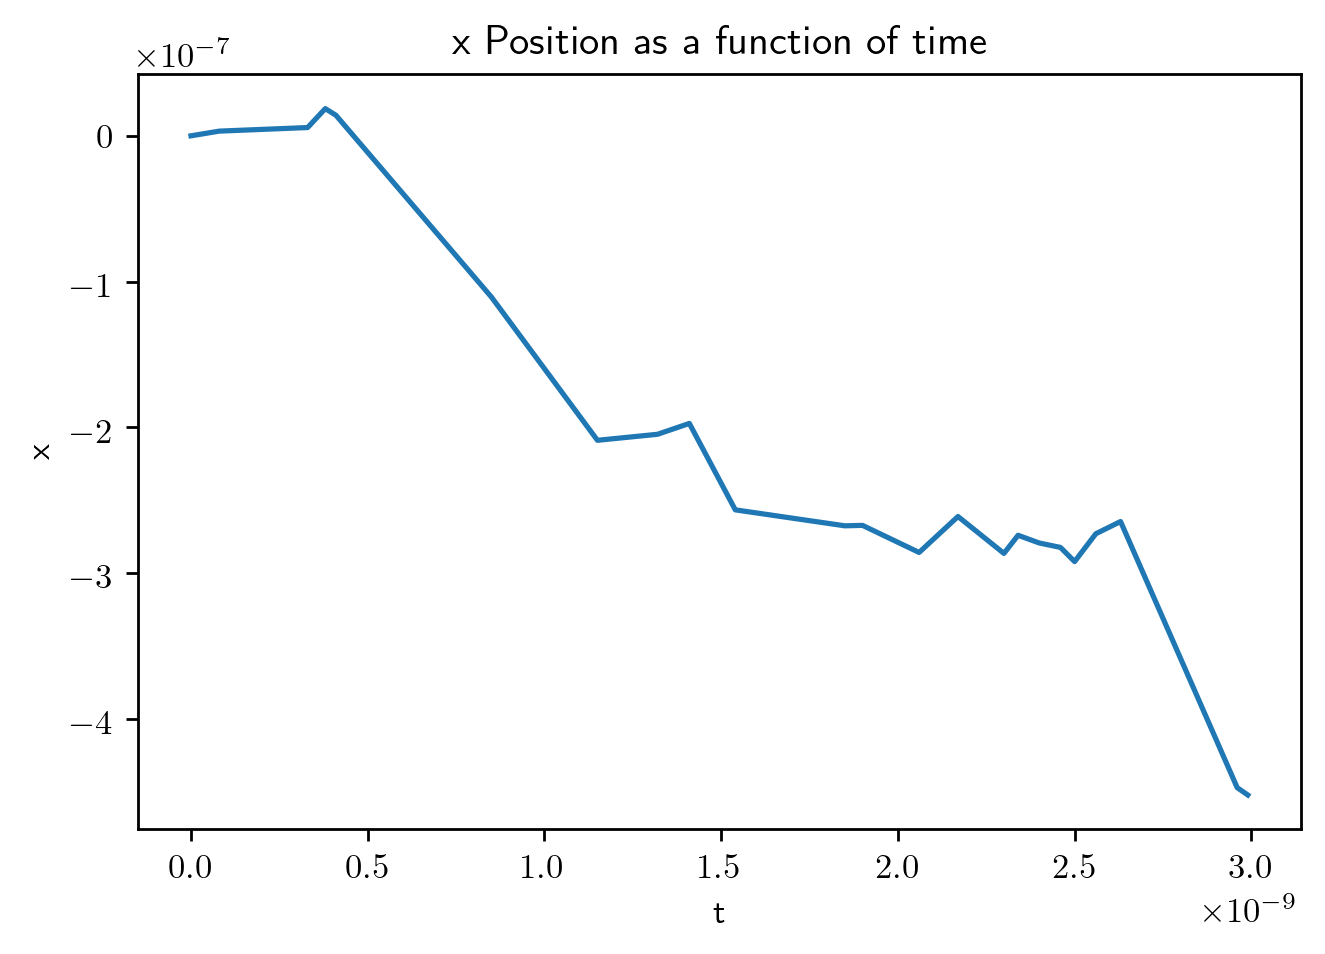

In [10]:
plt.title('x Position as a function of time')
plt.xlabel('t')
plt.ylabel('x')
plt.plot(df['t'], df['pos_x'])

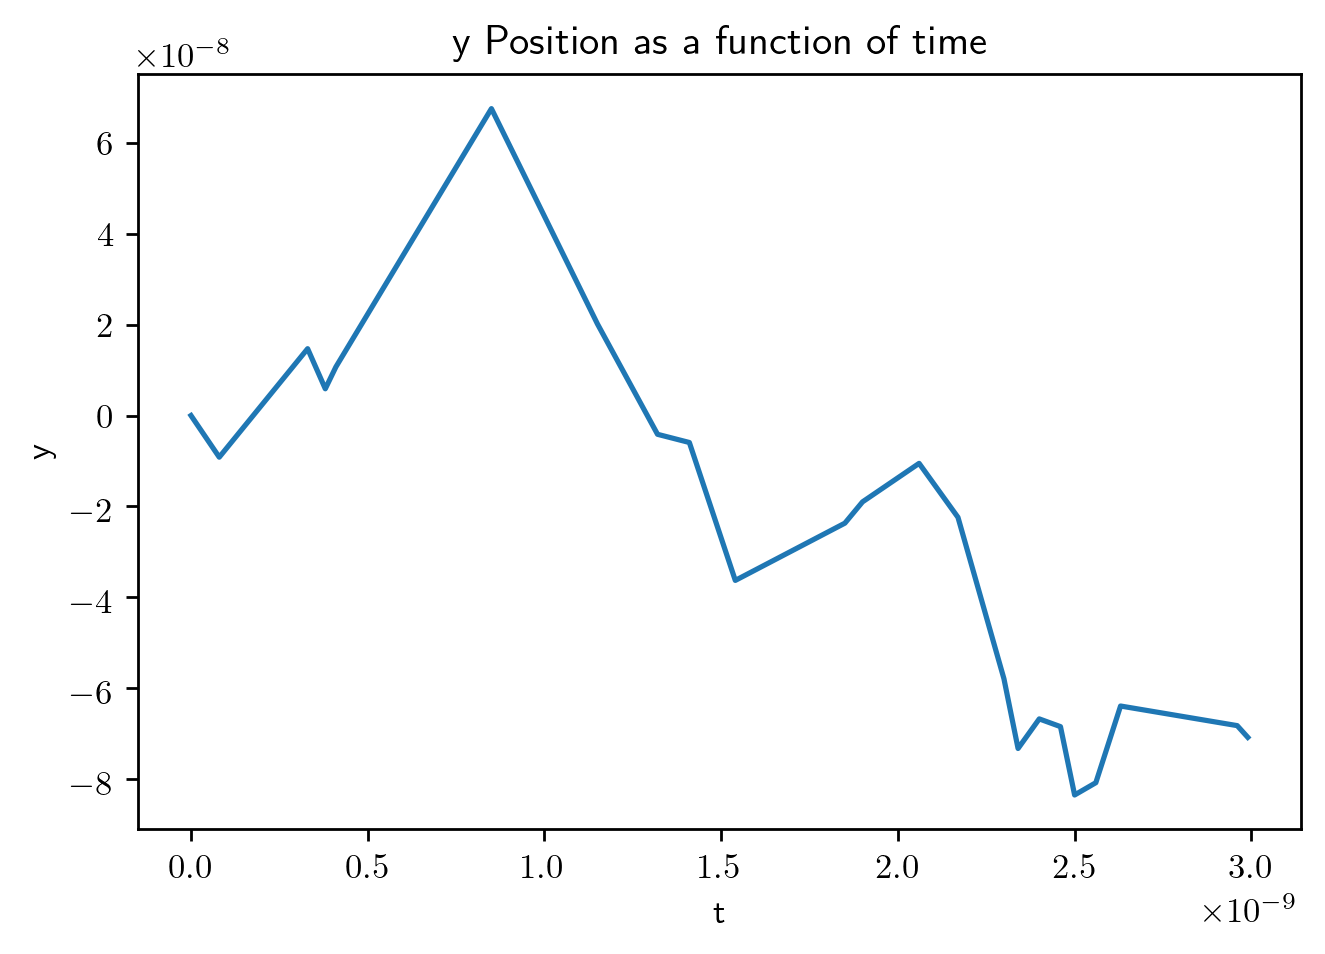

In [11]:
plt.title('y Position as a function of time')
plt.xlabel('t')
plt.ylabel('y')
plt.plot(df['t'], df['pos_y'])

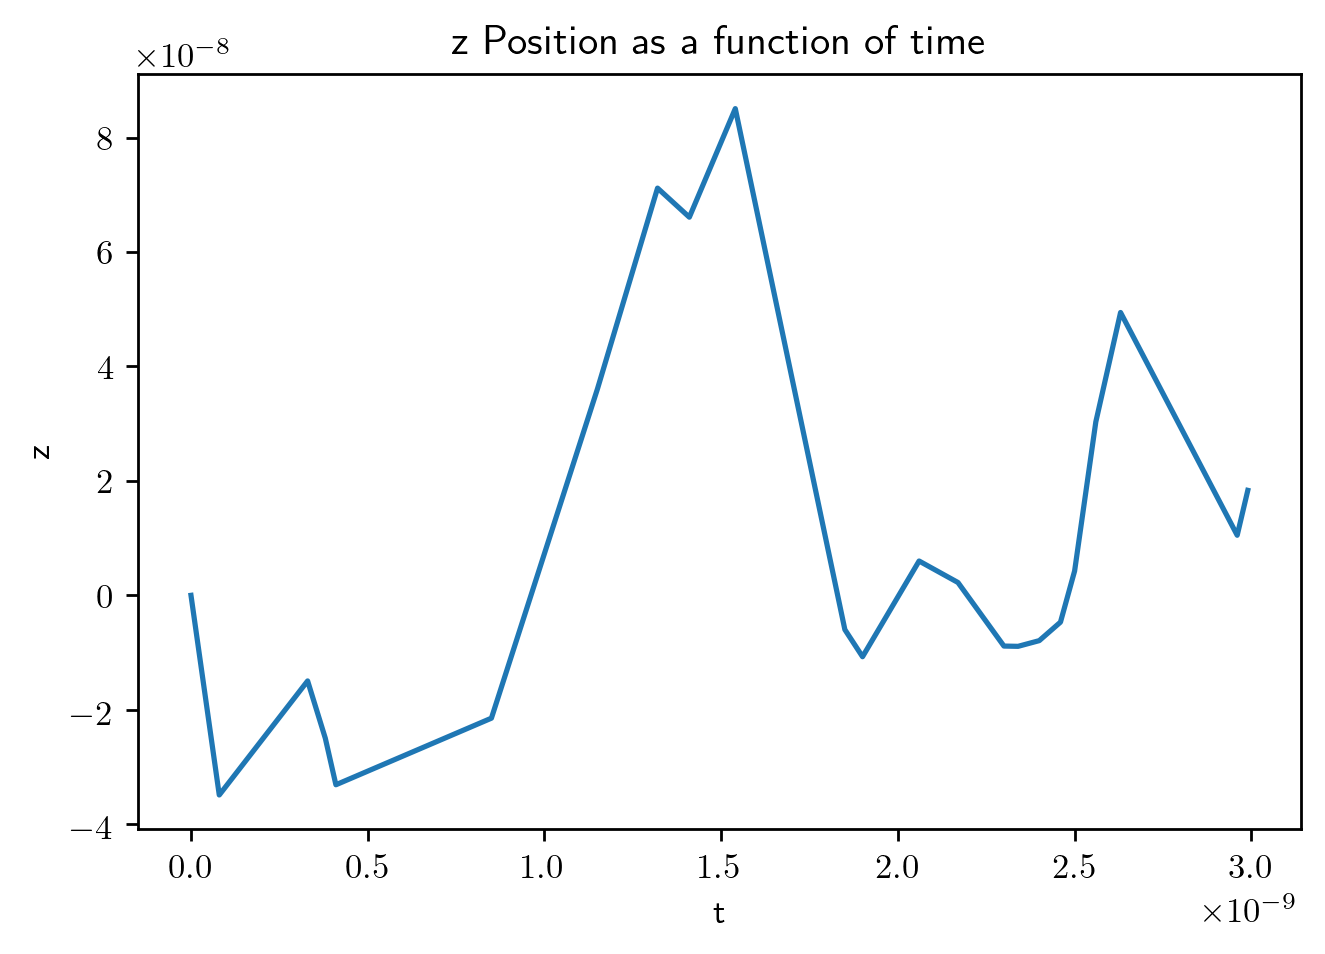

In [12]:
plt.title('z Position as a function of time')
plt.xlabel('t')
plt.ylabel('z')

plt.plot(df['t'], df['pos_z'])

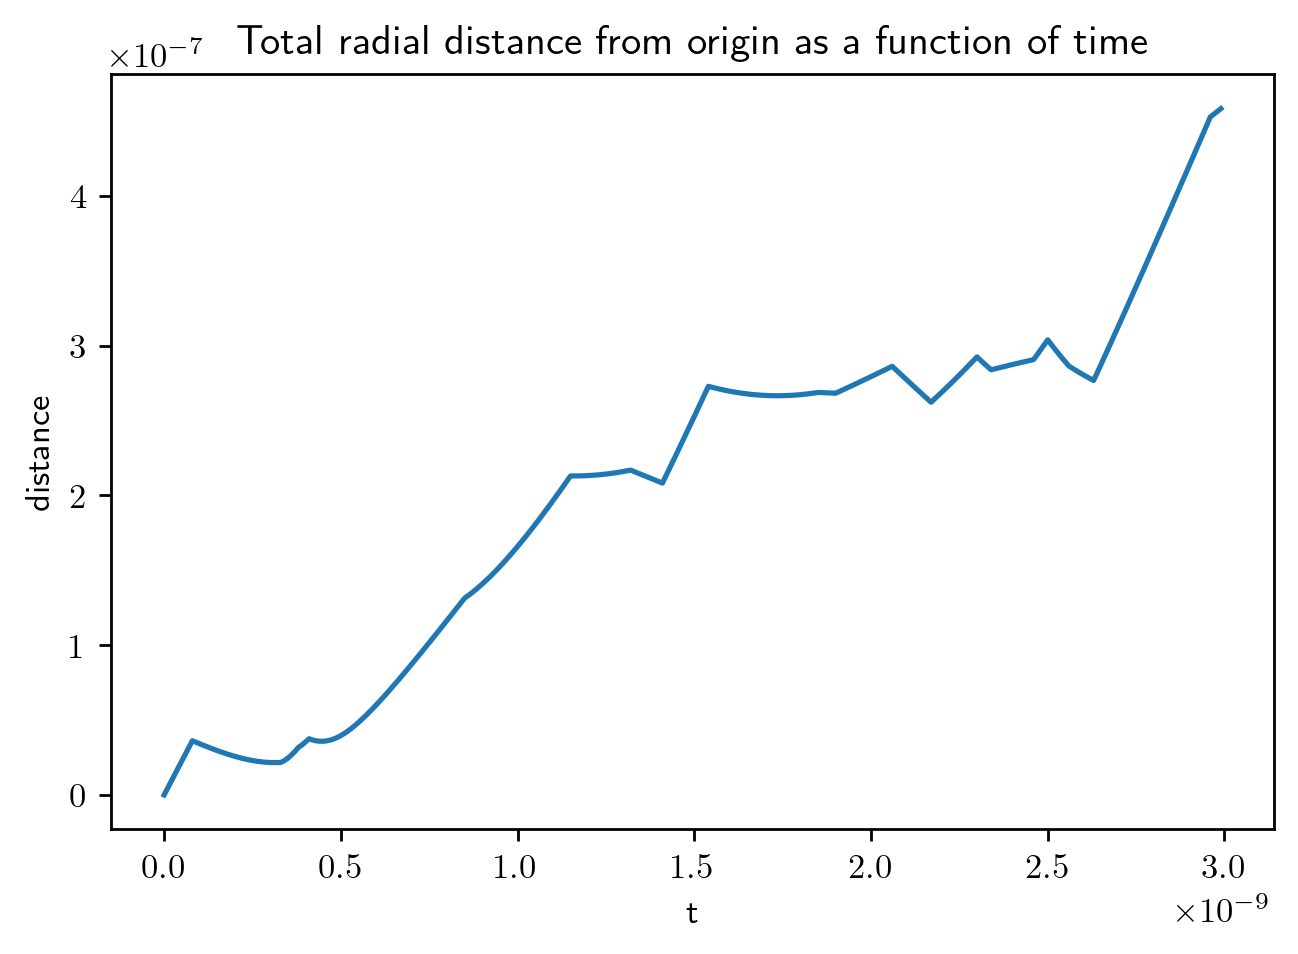

In [13]:
df['distance'] = (df['pos_x']**2 + df['pos_y']**2 + df['pos_z']**2)**(1/2)
plt.title('Total radial distance from origin as a function of time')
plt.xlabel('t')
plt.ylabel('distance')

plt.plot(df['t'], df['distance'])

## Question 3

(array([4., 3., 0., 2., 0., 1., 2., 2., 1., 1., 1., 0., 1., 0., 0., 2., 0.,
        1., 1., 1.]),
 array([0.00000000e+00, 5.31190800e-22, 1.06238160e-21, 1.59357240e-21,
        2.12476320e-21, 2.65595400e-21, 3.18714480e-21, 3.71833560e-21,
        4.24952640e-21, 4.78071720e-21, 5.31190800e-21, 5.84309881e-21,
        6.37428961e-21, 6.90548041e-21, 7.43667121e-21, 7.96786201e-21,
        8.49905281e-21, 9.03024361e-21, 9.56143441e-21, 1.00926252e-20,
        1.06238160e-20]),
 <a list of 20 Patch objects>)

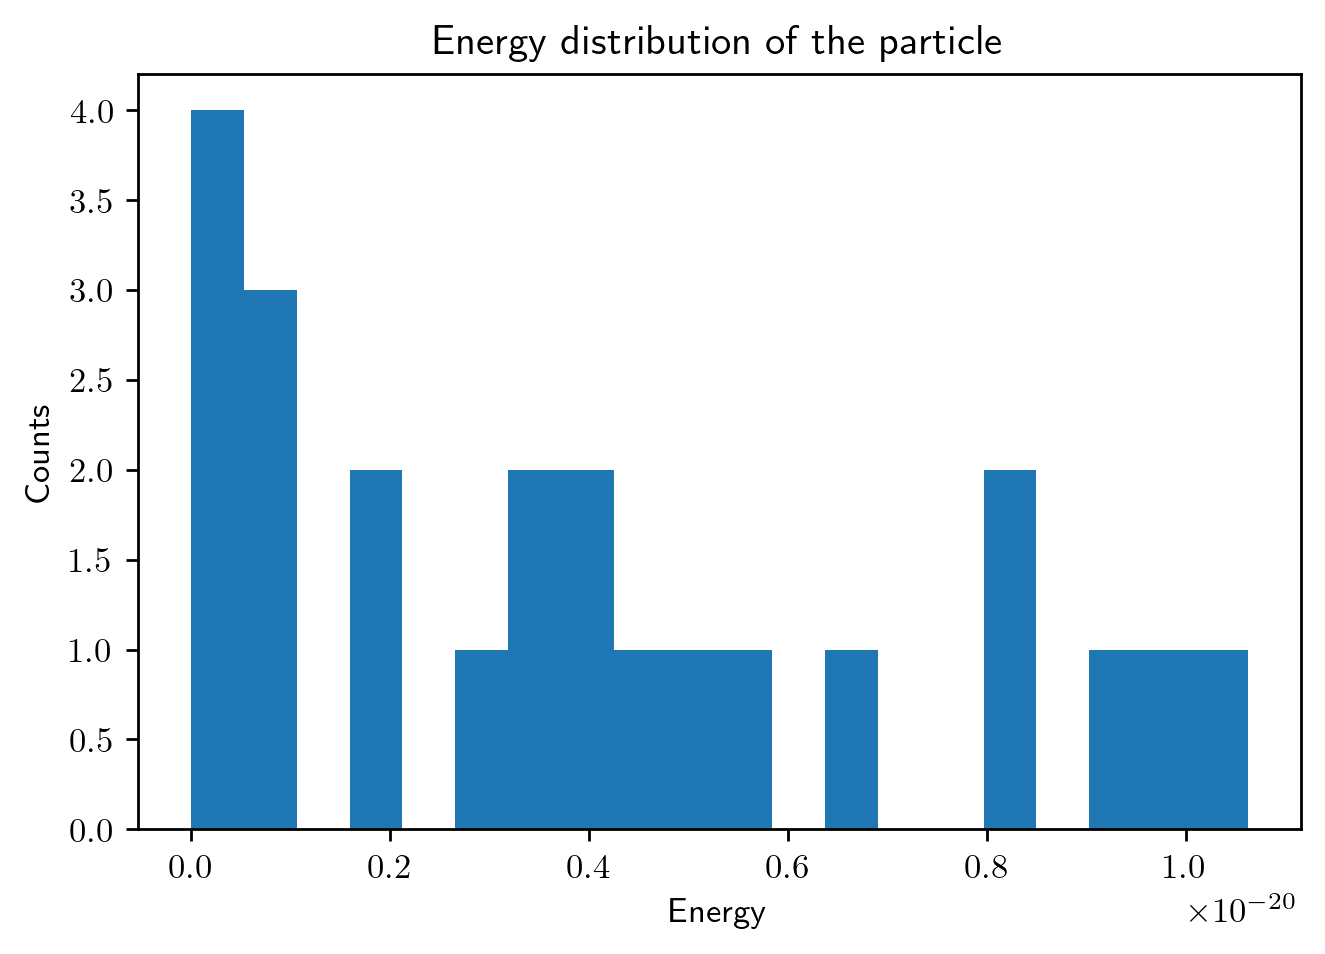

In [14]:
energies = df['energy'].unique()

plt.title('Energy distribution of the particle')
plt.xlabel('Energy')
plt.ylabel('Counts')

plt.hist(energies, bins=20)

This last cell isn't needed, but it just goes to show that the simulation that I wrote is the equivalent of actually sampling from a distribution (i.e. what Hallin wanted) Hallin says this approach is still ok, and this last calculation verifies it.

Mean Free Path is 4.243112910414296e-08


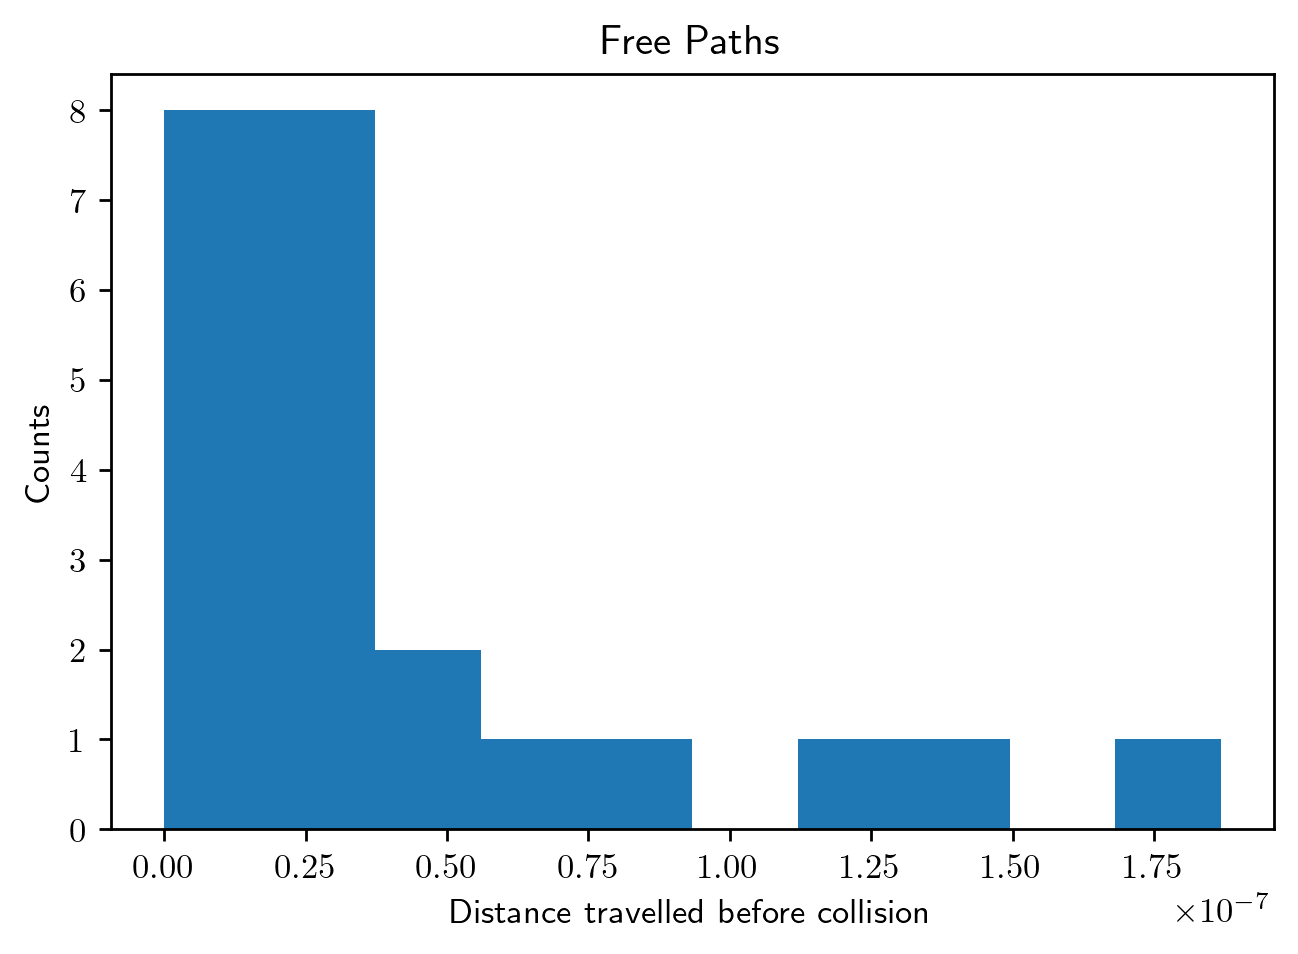

In [15]:
free_paths = np.load('./free_paths.npy')
plt.title('Free Paths')
plt.xlabel('Distance travelled before collision')
plt.ylabel('Counts')
plt.hist(free_paths, bins=10)
print(f'Mean Free Path is {np.mean(free_paths)}')

## Question 4

Repeating the simulation for 50000 particles with 5 trials, this took about 5 hours. But it is worth it!

In [16]:
q4_dfs = []

for i in range(1, 6):
    q4_dfs.append(pd.read_csv(f'./q4/monteCarlo_particle{i}.csv'))

Collisions per second: 7565656565.656566
Collisions per second: 8323232323.232324
Collisions per second: 7484848484.848485
Collisions per second: 7656565656.565657
Collisions per second: 8121212121.212121


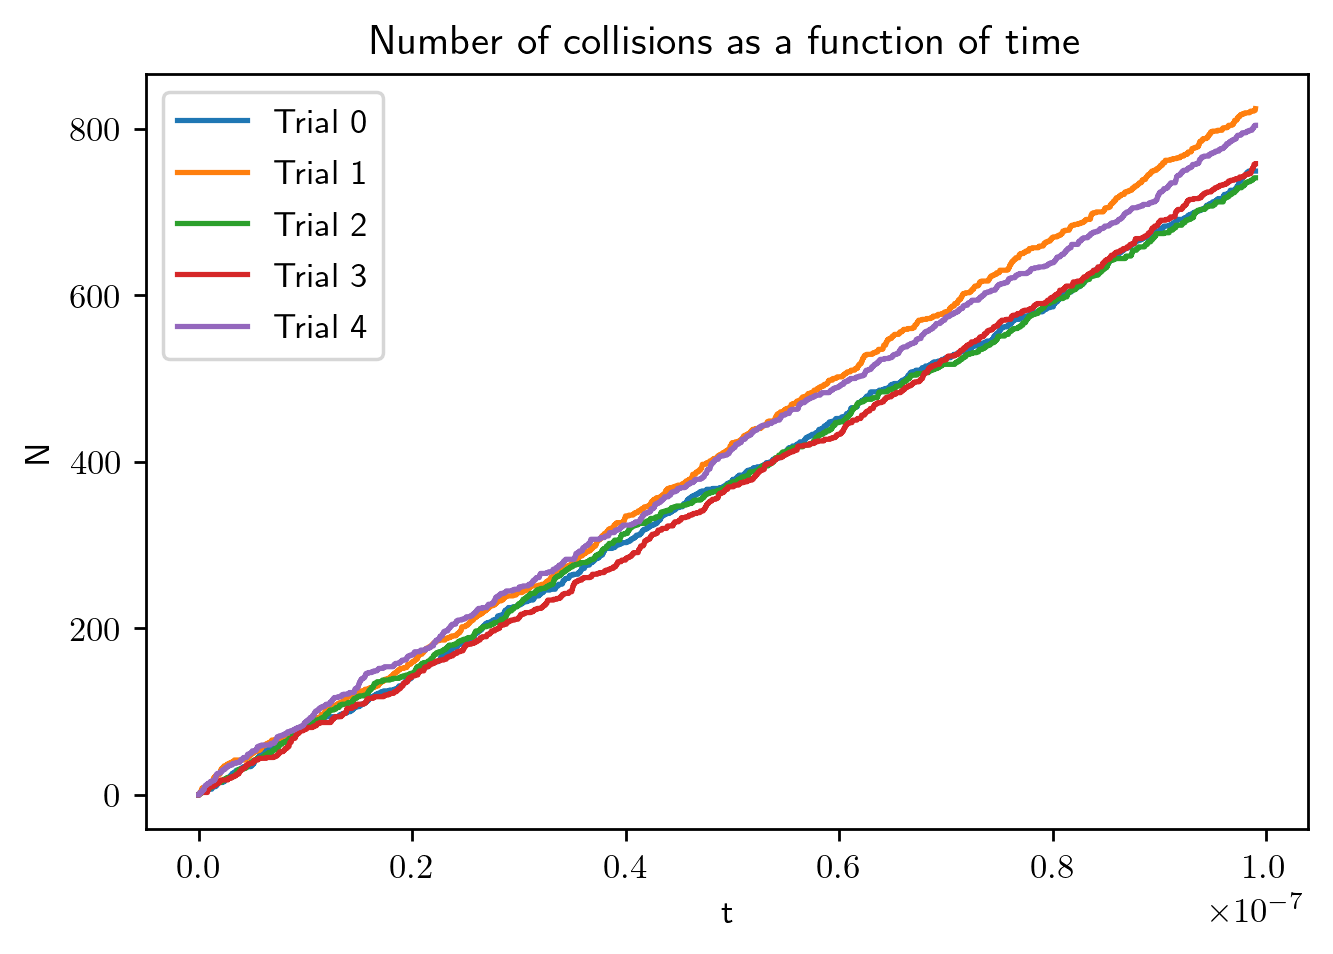

In [17]:

for i, df in enumerate(q4_dfs):
    plt.title('Number of collisions as a function of time')
    plt.xlabel('t')
    plt.ylabel('N')
    plt.plot(df['t'], df['collisions'], label=f'Trial {i}')


    N = df['collisions'].iloc[-1]
    t = df['t'].iloc[-1]
    print(f'Collisions per second: {N/t}')
plt.legend()

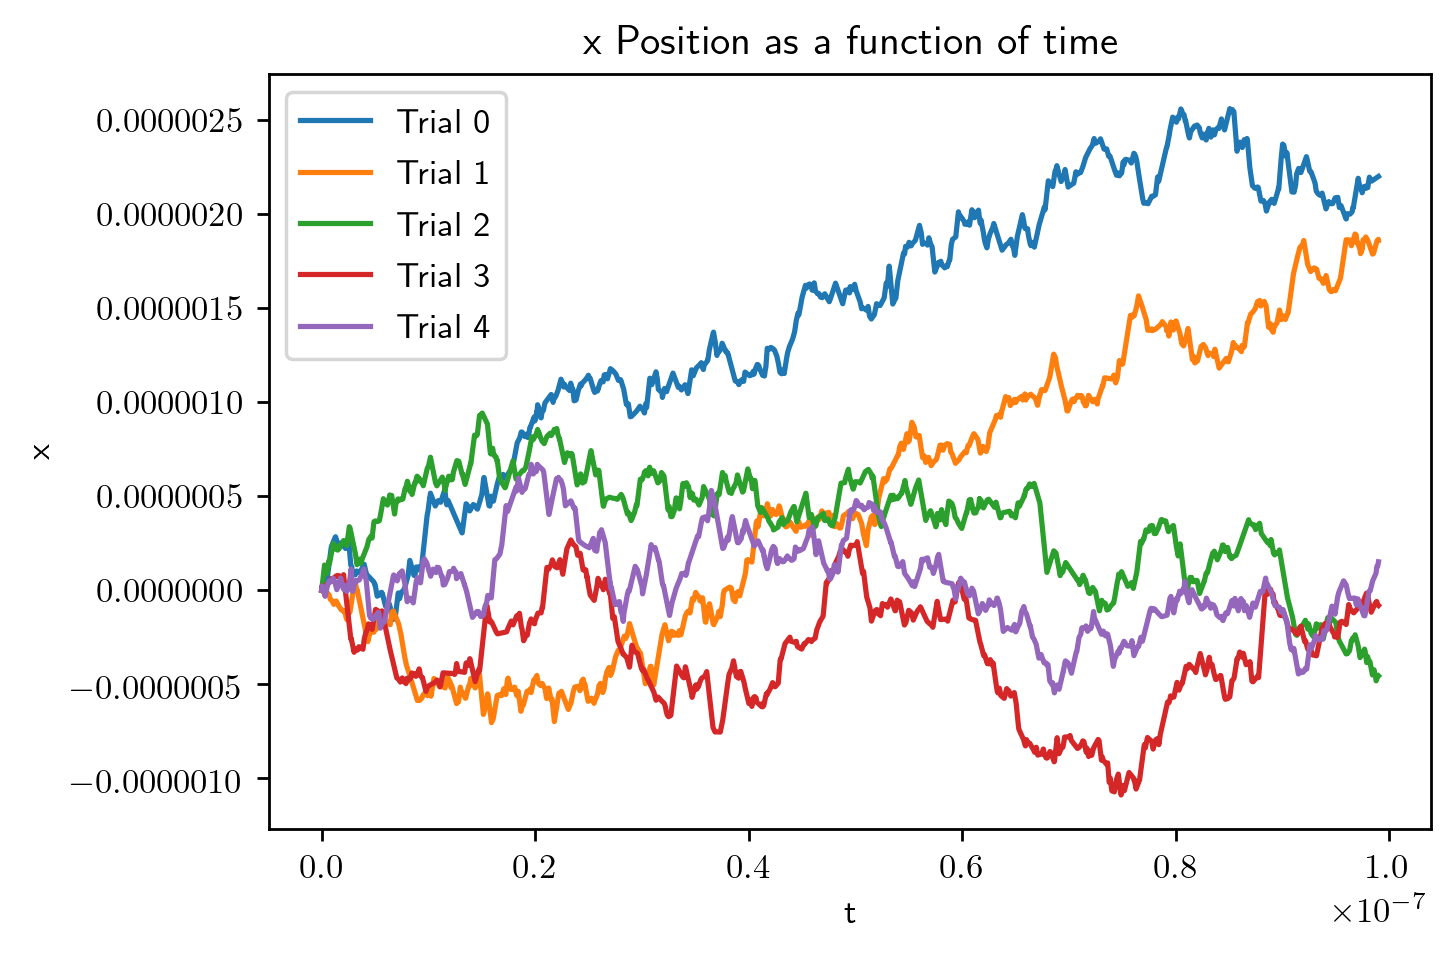

In [18]:
for i, df in enumerate(q4_dfs):
    plt.title('x Position as a function of time')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.plot(df['t'], df['pos_x'] , label=f'Trial {i}')
plt.legend()


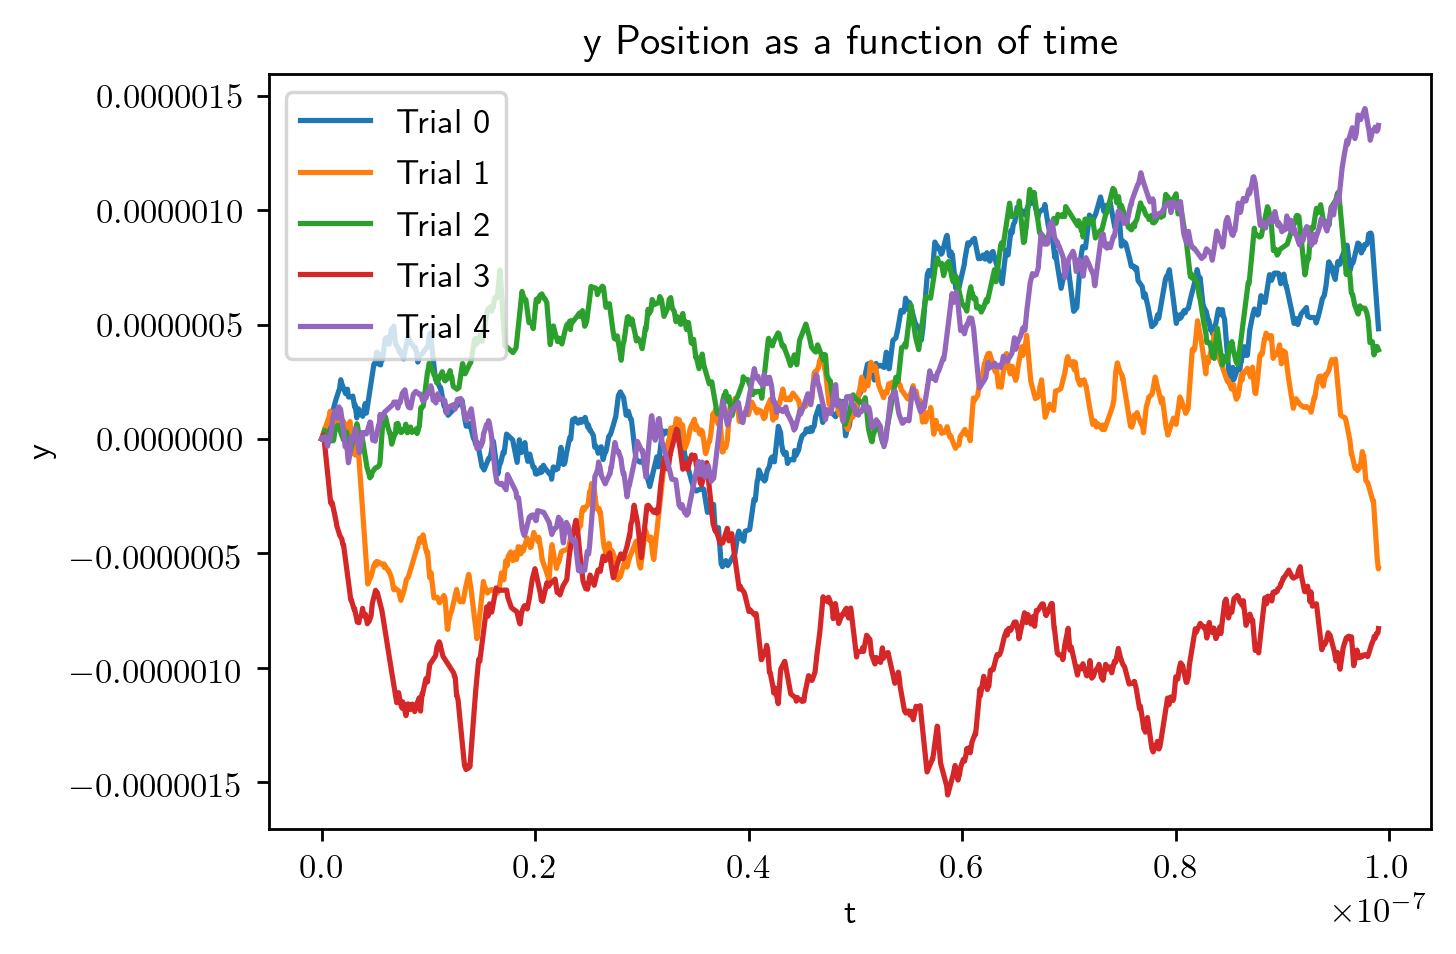

In [19]:
for i, df in enumerate(q4_dfs):
    plt.title('y Position as a function of time')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.plot(df['t'], df['pos_y'] , label=f'Trial {i}')
plt.legend()

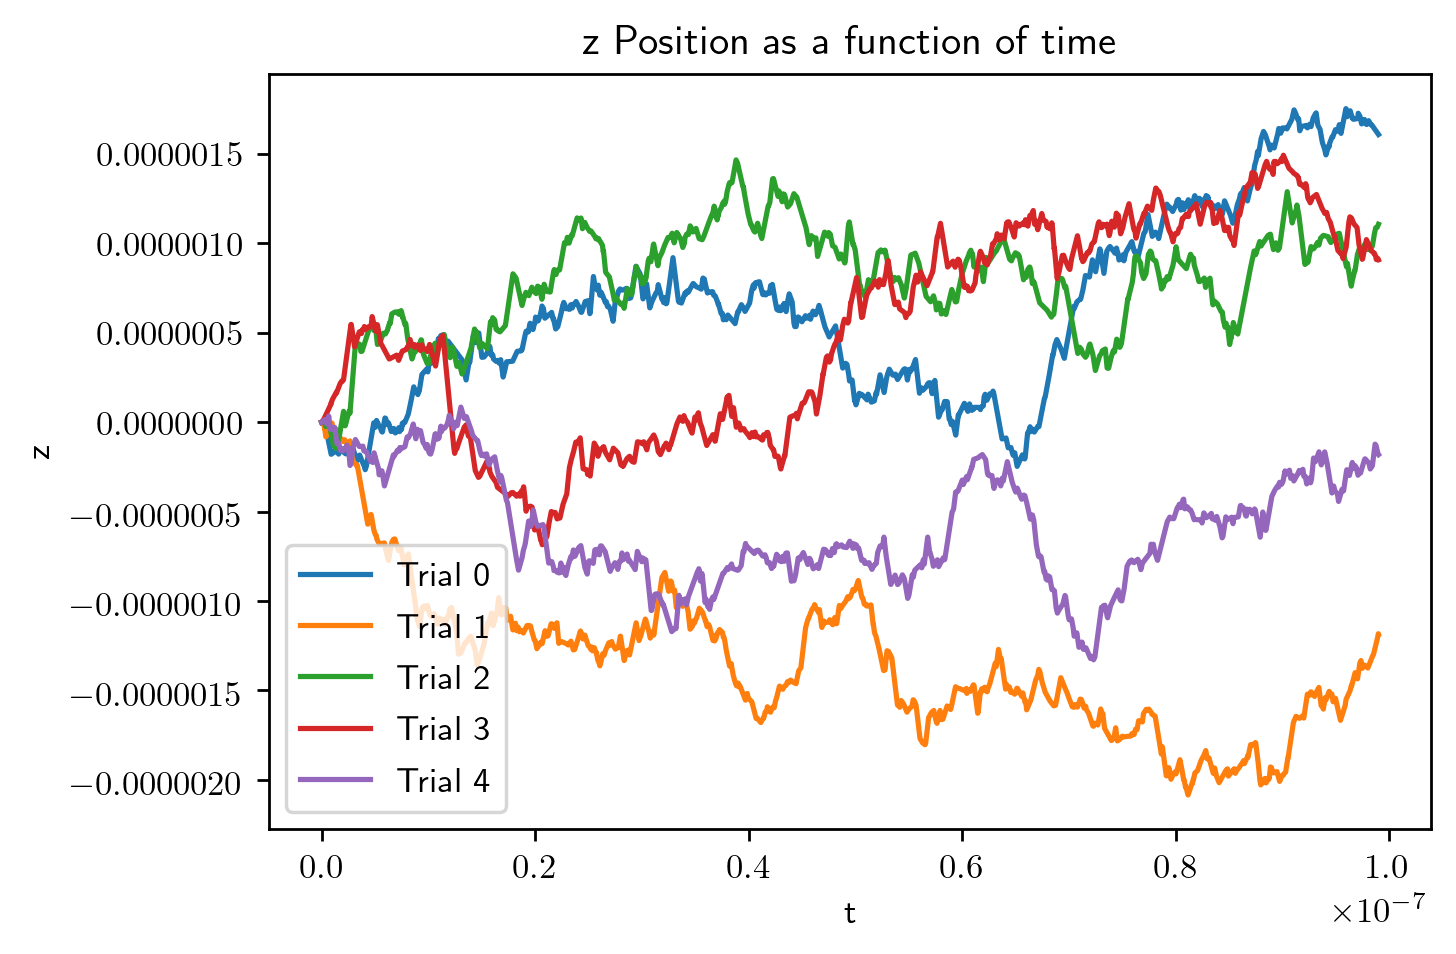

In [20]:
for i, df in enumerate(q4_dfs):
    plt.title('z Position as a function of time')
    plt.xlabel('t')
    plt.ylabel('z')
    plt.plot(df['t'], df['pos_z'] , label=f'Trial {i}')
plt.legend()

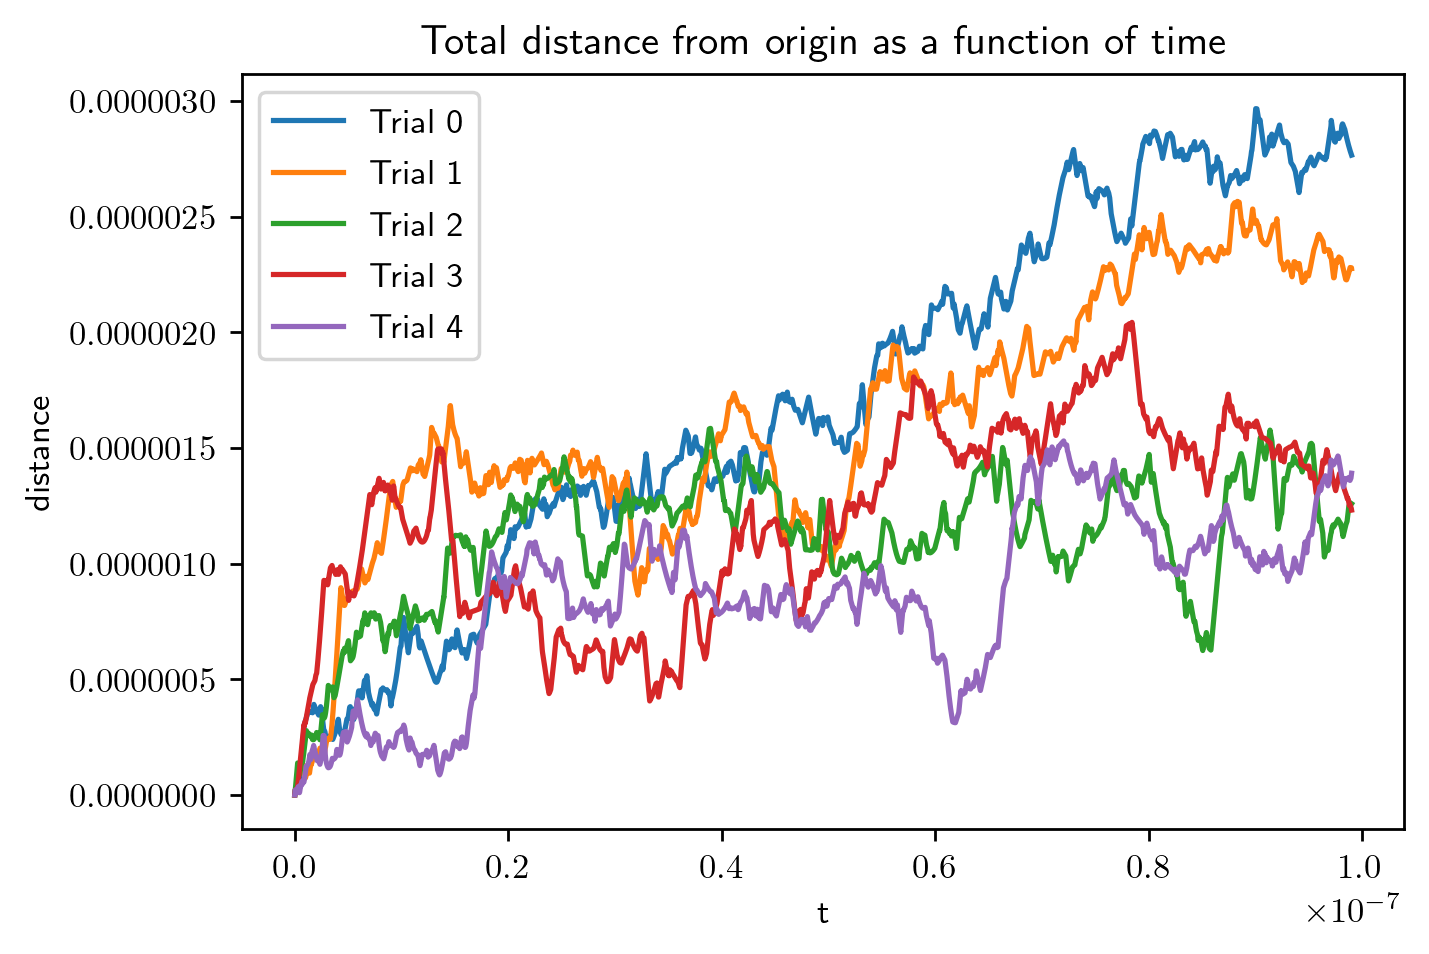

In [21]:
for i, df in enumerate(q4_dfs):
    df['distance'] = (df['pos_x']**2 + df['pos_y']**2 + df['pos_z']**2)**(1/2)
    plt.title('Total distance from origin as a function of time')
    plt.xlabel('t')
    plt.ylabel('distance')

    plt.plot(df['t'], df['distance'], label=f'Trial {i}')
plt.legend()

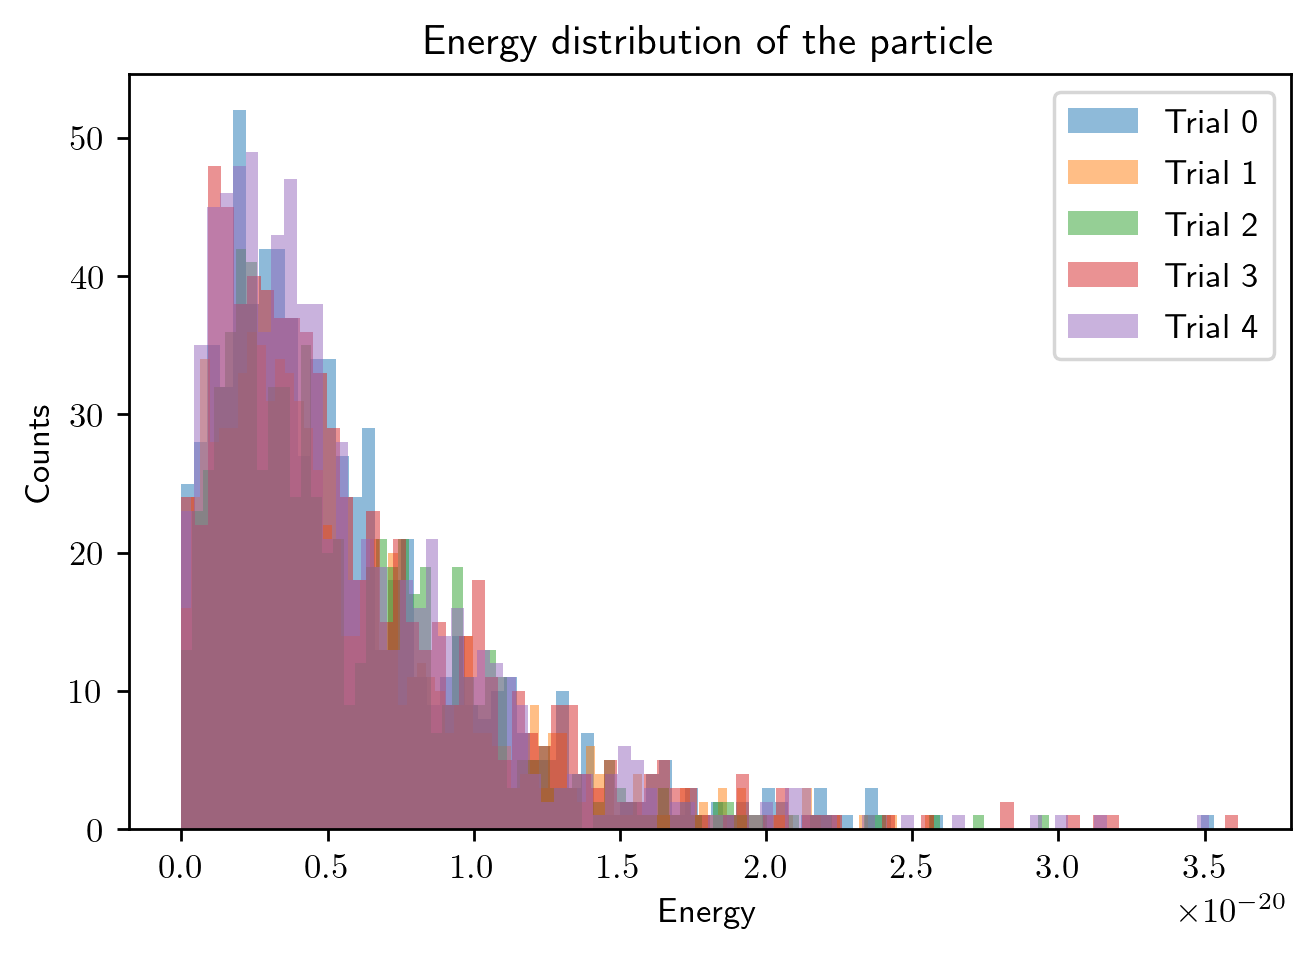

In [22]:
for i, df in enumerate(q4_dfs):
    energies = df['energy'].unique()

    plt.title('Energy distribution of the particle')
    plt.xlabel('Energy')
    plt.ylabel('Counts')

    plt.hist(energies, bins=80, alpha=0.5, label=f'Trial {i}')
plt.legend()

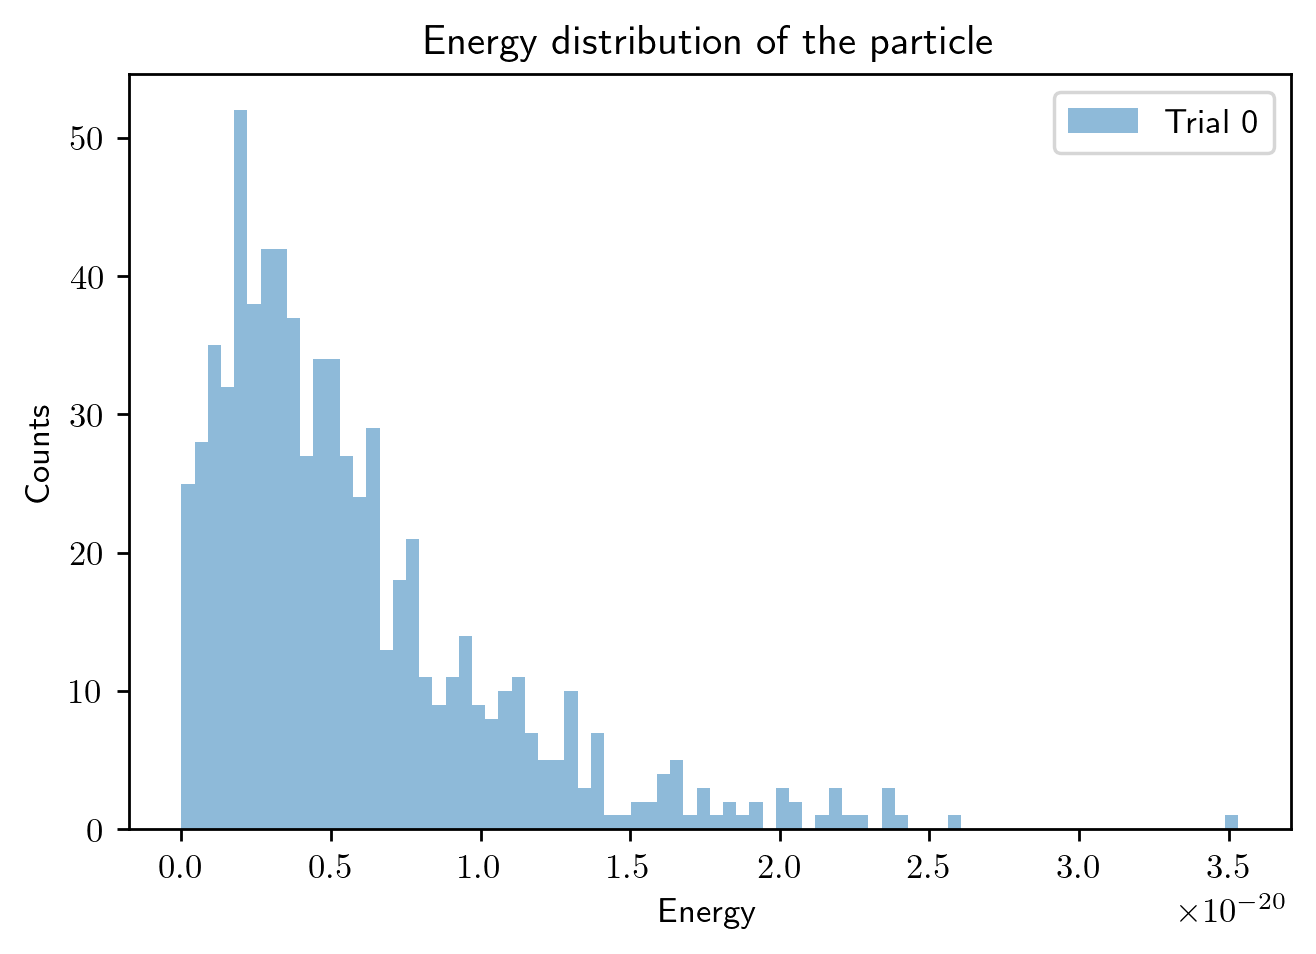

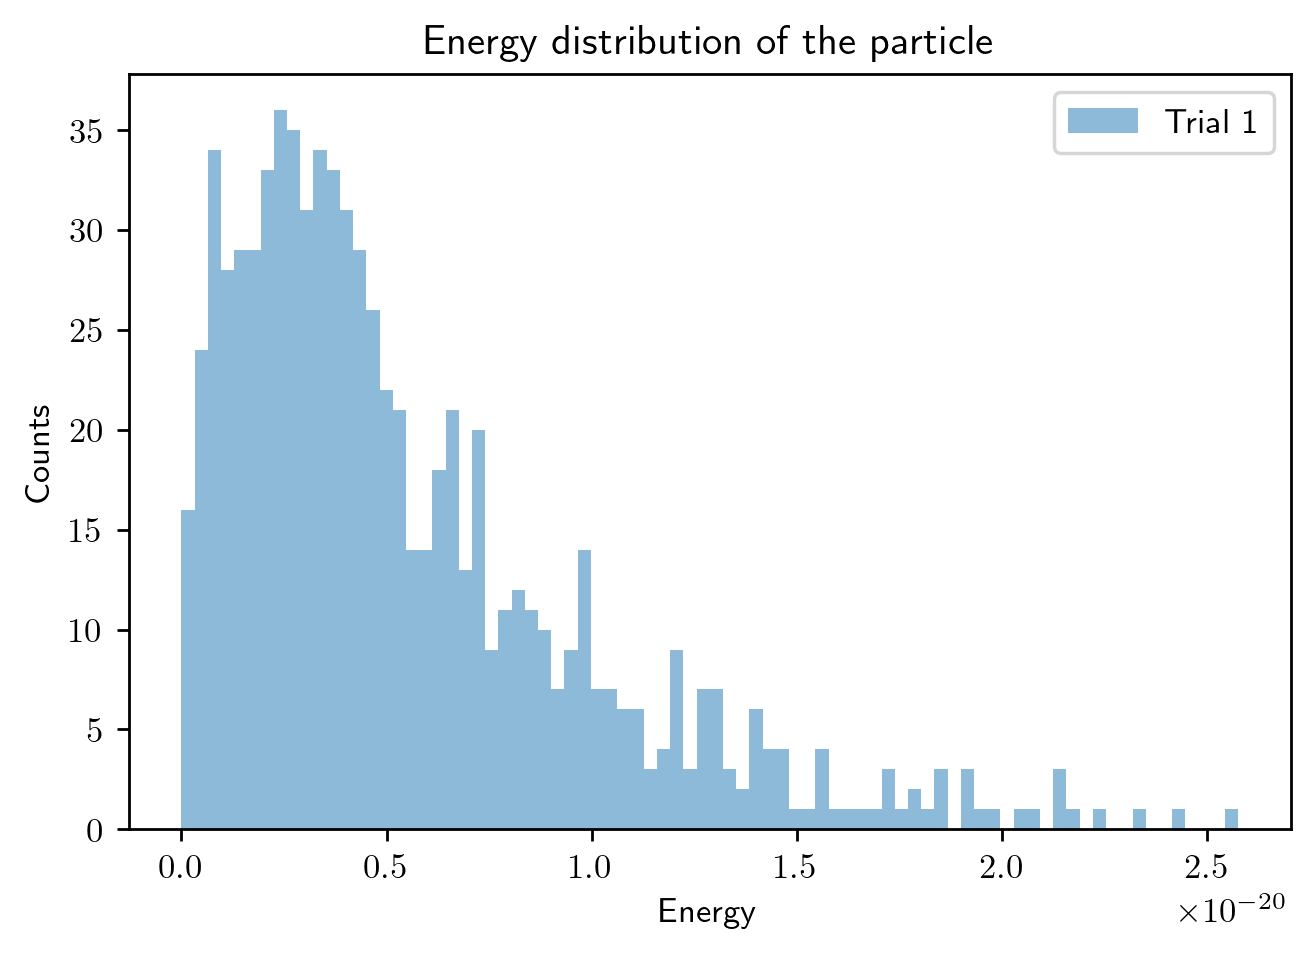

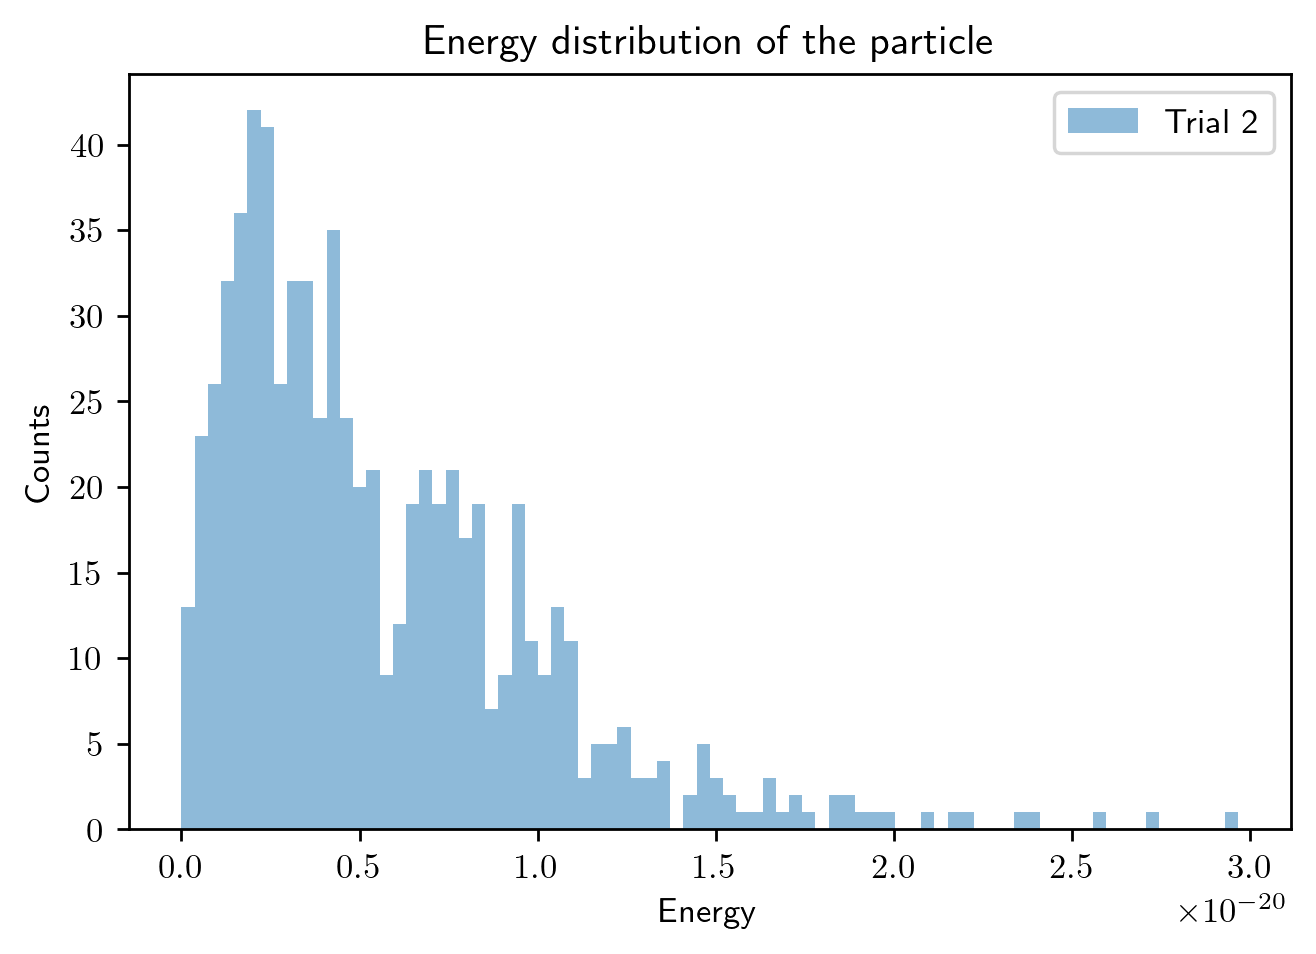

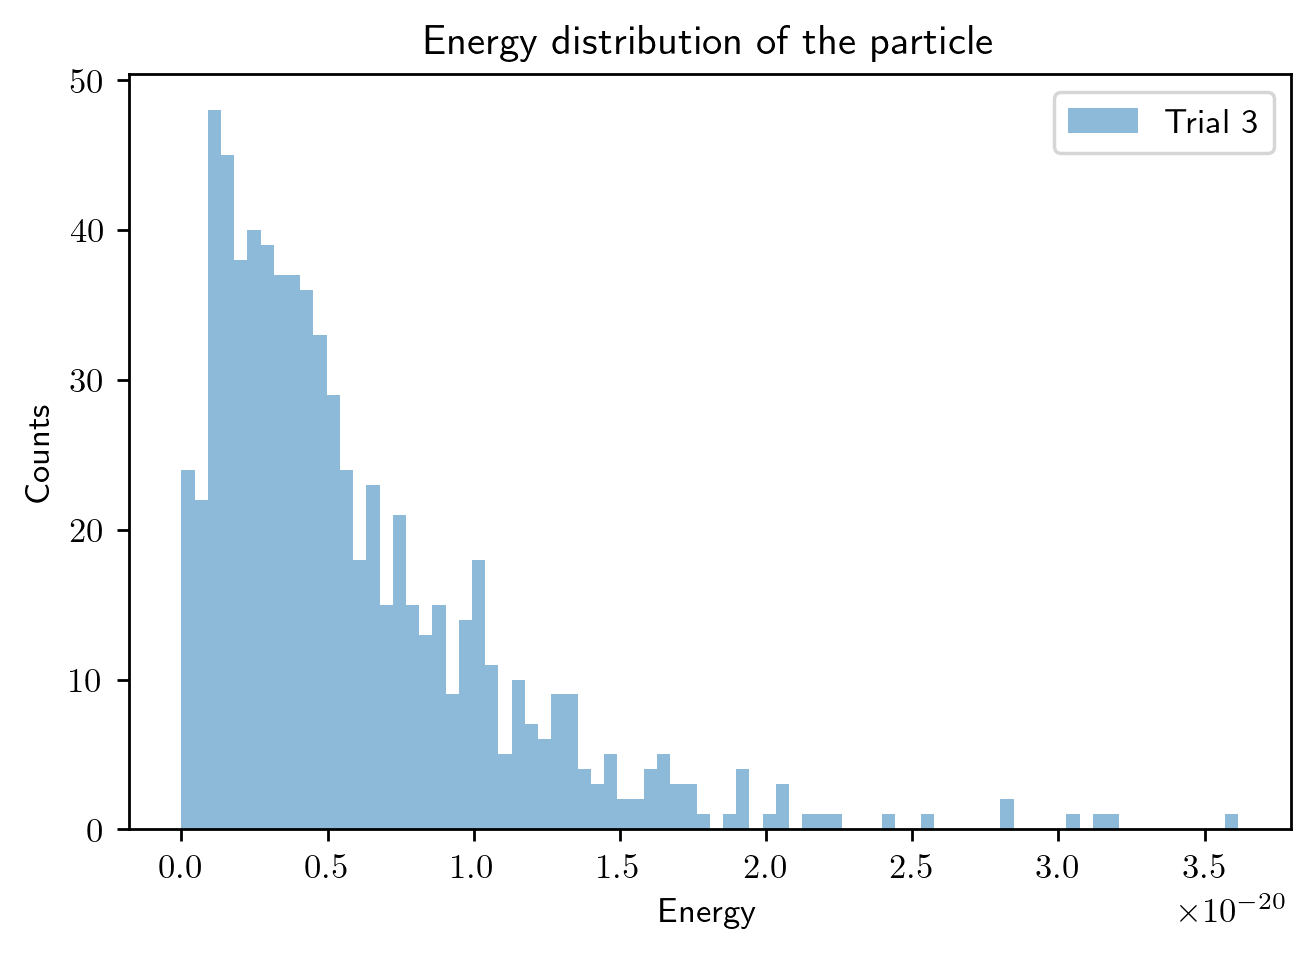

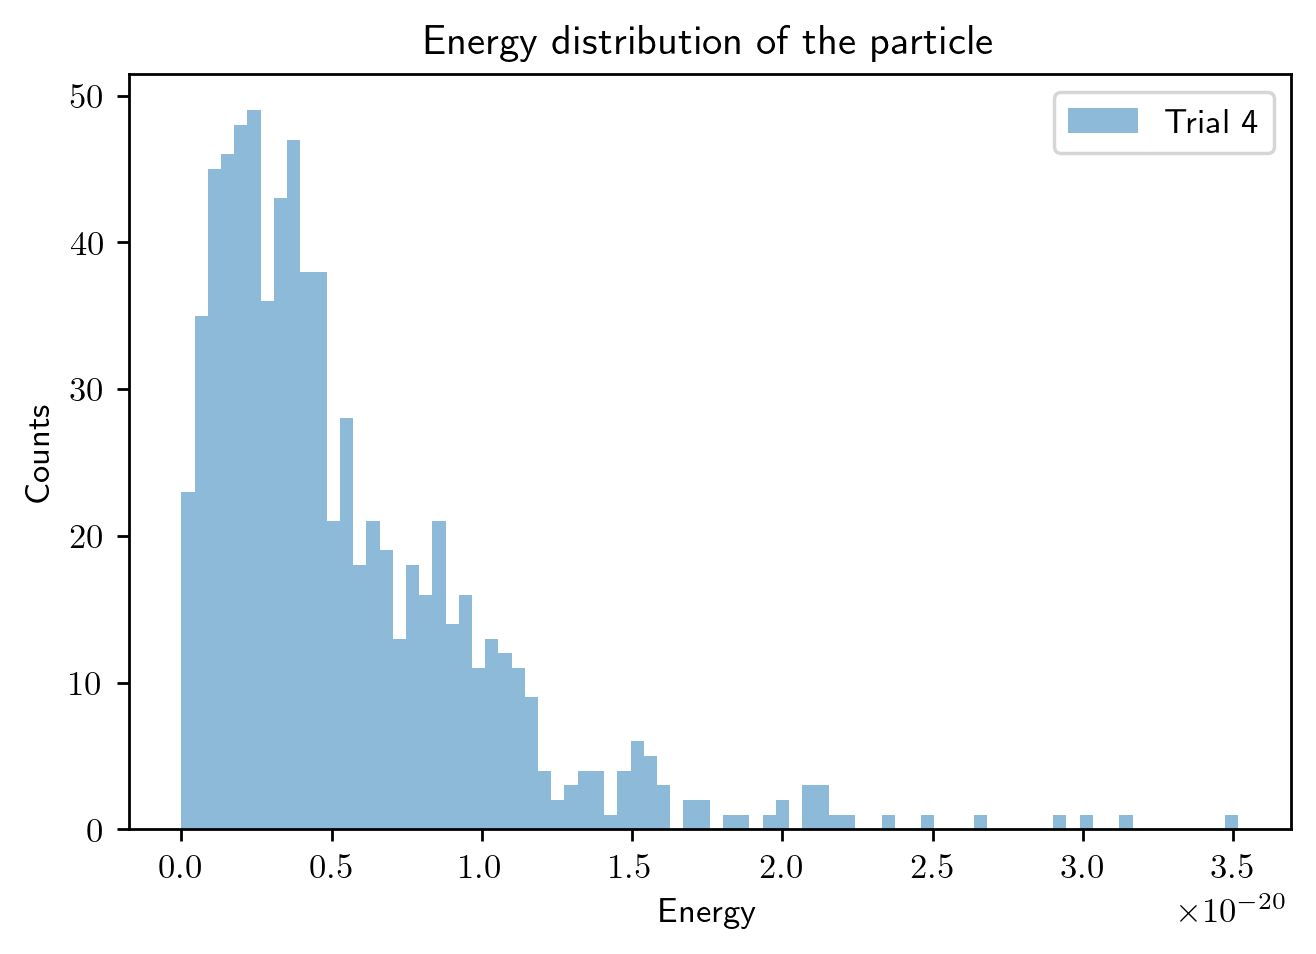

<Figure size 1500x1000 with 0 Axes>

In [23]:
for i, df in enumerate(q4_dfs):
    energies = df['energy'].unique()

    plt.title('Energy distribution of the particle')
    plt.xlabel('Energy')
    plt.ylabel('Counts')

    plt.hist(energies, bins=80, alpha=0.5, label=f'Trial {i}')
    plt.legend()
    plt.figure()

Mean Free Path is 4.946016914230296e-08
Mean Free Path is 4.6302760847993996e-08
Mean Free Path is 5.251513076859884e-08
Mean Free Path is 5.0583040057537357e-08
Mean Free Path is 4.6800607189594436e-08


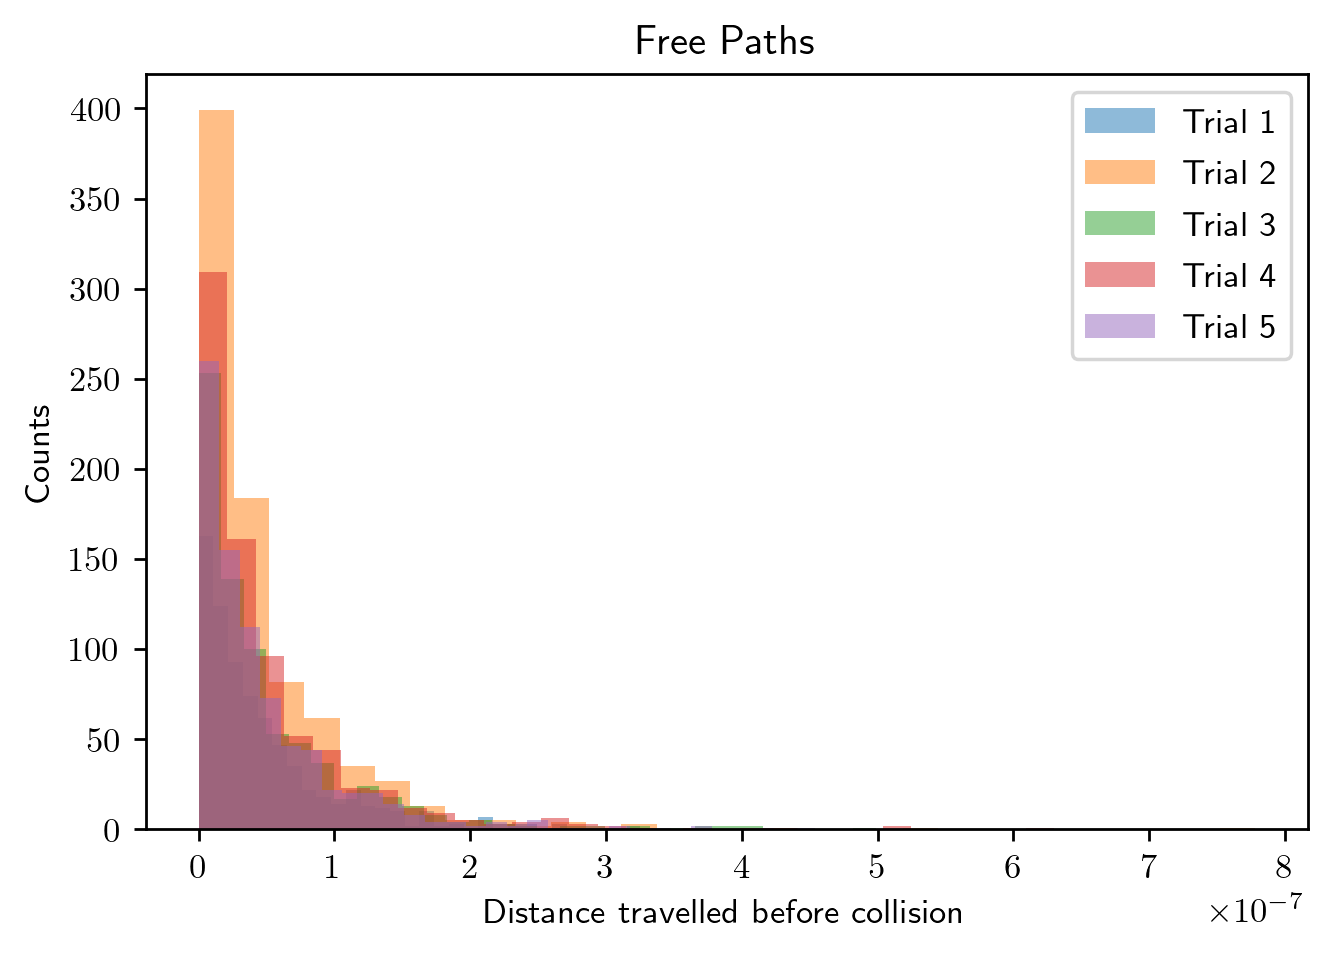

In [24]:
for i in range(1, 6):
    free_paths = np.load(f'./q4/free_paths{i}.npy')
    plt.title('Free Paths')
    plt.xlabel('Distance travelled before collision')
    plt.ylabel('Counts')
    plt.hist(free_paths, bins=30, alpha=0.5, label=f'Trial {i}')
    print(f'Mean Free Path is {np.mean(free_paths)}')
plt.legend()

Energy and mean free path distributions look right! The mean free path distribution looks exponential, which is correct if I had just sampled from the exponential distribution in the first place. But I didn't and did it the tedious way. But at least I got something that looks reasonable. Consider this an "experimental verification" of the theory!